In [ ]:
!git clone https://github.com/haipradana/roberta-indonesian-hate-tweet.git
%cd roberta-indonesian-hate-tweet

Cloning into 'roberta-indonesian-hate-tweet'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 42 (delta 22), reused 30 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 1.91 MiB | 20.40 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/kaggle/working/roberta-indonesian-hate-tweet


In [2]:
!pip install -q transformers datasets accelerate evaluate scikit-learn matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires nump

In [3]:
import torch
from datasets import load_dataset, Features, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
import pandas as pd
import os
from datetime import datetime
import evaluate 
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt

2025-06-22 00:55:02.914192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750553703.105517      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750553703.162536      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Configuration set-up

In [4]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
dataset_path = 'dataset/dataset.csv'

output_dir = "finetune_output"
os.makedirs(output_dir, exist_ok=True)

# Mapping label to id (numerical)
classes = ["neutral", "hate"]
label2id =  {label: i for i, label in enumerate(classes)}
id2label =  {i: label for i, label in enumerate(classes)}

NUM_LABELS = len(classes)

## Load Tokenizer and Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_LABELS, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

## Prepare dataset for training

In [6]:
from datasets import Value

features = Features(
    {'text': Value('string'), 
     'label': ClassLabel(names=classes)}
)
dataset = load_dataset('csv', data_files={'train':dataset_path}, features=features)

def tokenize_func(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=511)

tokenized_datasets = dataset.map(tokenize_func, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# split data into 70/15/15
train_val_dataset = tokenized_datasets["train"].train_test_split(test_size=0.15, seed=42)
train_test_split = train_val_dataset['train'].train_test_split(test_size=0.15/0.85, seed=42)

train_dataset = train_test_split['train']
eval_dataset = train_test_split['test'] # validation set
test_dataset = train_val_dataset['test'] # test set

print(f"Total training: {len(train_dataset)} ({len(train_dataset)/len(tokenized_datasets['train']):.0%})")
print(f"Total validasi: {len(eval_dataset)} ({len(eval_dataset)/len(tokenized_datasets['train']):.0%})")
print(f"Total test: {len(test_dataset)} ({len(test_dataset)/len(tokenized_datasets['train']):.0%})")

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/18148 [00:00<?, ? examples/s]

Total training: 12702 (70%)
Total validasi: 2723 (15%)
Total test: 2723 (15%)


## Configure metrics

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # pos_label=1 because 'hate' is a second classes (index 1)
    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    precision = precision_score(y_true=labels, y_pred=predictions, average='weighted')
    recall = recall_score(y_true=labels, y_pred=predictions, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted')
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [8]:
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="none",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_ratio=0.08,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", 
)

In [9]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
    compute_metrics=compute_metrics, tokenizer=tokenizer, callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]
)

/tmp/ipykernel_35/880166735.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training

In [10]:
print("Starting...")
trainer.train()
print("Fine-tuning completed!")

Starting...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.549700,0.437731,0.802424,0.804289,0.802424,0.801939
2,0.375900,0.416408,0.824458,0.824553,0.824458,0.824470


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fine-tuning completed!


## Logs

In [11]:
logs = trainer.state.log_history
log_df = pd.DataFrame(logs)
log_df.to_csv(os.path.join(output_dir, "training_logs.csv"), index=False)
print('Training Log saved!')

Training Log saved!


# Evaluation

In [12]:
predictions_output = trainer.predict(test_dataset)

pred_labels = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [13]:
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, pos_label=1)
recall = recall_score(true_labels, pred_labels, pos_label=1)
f1 = f1_score(true_labels, pred_labels, pos_label=1)

In [14]:
print("\n===== Final Report of Test Set Performance =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")


===== Final Report of Test Set Performance =====
Accuracy: 0.8201
Precision (weighted): 0.8268
Recall (weighted): 0.8172
F1-Score (weighted): 0.8219


In [15]:
final_metrics_report = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
with open(os.path.join(output_dir, "final_metrics_report.txt"), "w") as f:
    f.write(str(final_metrics_report))

Confusion matrix disimpan di: finetune_output/confusion_matrix.png


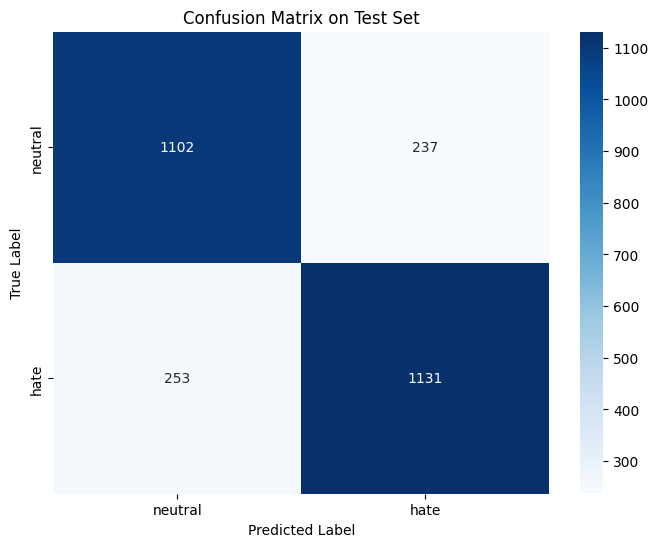

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
conf_matrix_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
print(f"Confusion matrix disimpan di: {conf_matrix_path}")
plt.show()